# **IMPORTS**

In [46]:
import numpy as np
import pandas as pd
import gzip, random
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm
from scipy.sparse import csr_matrix
import networkx as nx
import community as community_louvain
from tqdm.notebook import tqdm  # Progress bars for Jupyter

In [47]:
data_path = r"C:\Users\hugoj\Documents\Cours\MA3\ADA\YouNiverse\Datasets\4650046"
comments_file = "youtube_comments.tsv.gz"
videos_file = "yt_metadata_en.jsonl.gz"
comments_path = os.path.join(data_path, comments_file)
videos_path = os.path.join(data_path, videos_file)

# **TEST COMMENTS**

In [50]:
# Load the comment data
# Using efficient dtypes to minimize memory usage
N_ROWS = 10_000_000  # Load first 10M rows for faster testing

print(f"Loading first {N_ROWS:,} rows from data file...")

# Load with string dtypes first (faster), then convert to category
# This is much faster than converting during load
chunks_df = pd.read_csv('/Users/albertfares/Desktop/4650046/youtube_comments.tsv', 
                 sep='\t',
                 nrows=N_ROWS,  # Only load first 10M rows
                 dtype={'author': 'str', 
                        'video_id': 'str', 
                        'likes': 'int32', 
                        'replies': 'int32'})

print(f"Data loaded! Converting to efficient dtypes...")

# Convert to category after loading (faster than during load)
chunks_df['author'] = chunks_df['author'].astype('category')
chunks_df['video_id'] = chunks_df['video_id'].astype('category')

print(f"\nData loaded successfully!")
print(f"Shape: {chunks_df.shape}")
print(f"Memory usage: {chunks_df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"Note: Using first {N_ROWS:,} rows for faster testing")


Loading first 10,000,000 rows from data file...
Data loaded! Converting to efficient dtypes...

Data loaded successfully!
Shape: (10000000, 4)
Memory usage: 0.55 GB
Note: Using first 10,000,000 rows for faster testing


In [51]:
MIN_VIDEOS_PER_USER = 5
MIN_USERS_PER_VIDEO = 10

df = chunks_df.copy()

for it in range(10):  # safety cap (usually converges in 2–3)
    print(f"🔁 Iteration {it+1}")

    # 1️⃣ Filter users by how many distinct videos they commented on
    user_counts = df.groupby('author')['video_id'].nunique()
    valid_users = user_counts[user_counts >= MIN_VIDEOS_PER_USER].index

    # 2️⃣ Filter videos by how many distinct valid commenters they have
    video_counts = df[df['author'].isin(valid_users)].groupby('video_id')['author'].nunique()
    valid_videos = video_counts[video_counts >= MIN_USERS_PER_VIDEO].index

    # 3️⃣ Apply both filters
    new_df = df[
        df['author'].isin(valid_users) &
        df['video_id'].isin(valid_videos)
    ].reset_index(drop=True)

    # 4️⃣ Check for convergence
    diff = len(df) - len(new_df)
    print(f"   Rows kept: {len(new_df):,}  (dropped {diff:,})")

    if diff == 0:
        print("✅ Converged — filtering complete.")
        break

    df = new_df

# 🎯 Final results
filtered_df = df.copy()

# Save final valid sets
final_valid_users = set(valid_users)
final_valid_videos = set(valid_videos)

print(f"Original size: {len(chunks_df):,}")
print(f"Filtered size: {len(filtered_df):,}")
print(f"Remaining users: {filtered_df['author'].nunique():,}")
print(f"Remaining videos: {filtered_df['video_id'].nunique():,}")

🔁 Iteration 1


/var/folders/s9/qzfnyl8j1hqb_tsw2bpl5bbc0000gn/T/ipykernel_7272/2715354706.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_counts = df.groupby('author')['video_id'].nunique()
/var/folders/s9/qzfnyl8j1hqb_tsw2bpl5bbc0000gn/T/ipykernel_7272/2715354706.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  video_counts = df[df['author'].isin(valid_users)].groupby('video_id')['author'].nunique()


   Rows kept: 2,170,229  (dropped 7,829,771)
🔁 Iteration 2
   Rows kept: 1,875,879  (dropped 294,350)
🔁 Iteration 3
   Rows kept: 1,843,474  (dropped 32,405)
🔁 Iteration 4
   Rows kept: 1,836,757  (dropped 6,717)
🔁 Iteration 5
   Rows kept: 1,835,125  (dropped 1,632)
🔁 Iteration 6
   Rows kept: 1,834,410  (dropped 715)
🔁 Iteration 7
   Rows kept: 1,834,105  (dropped 305)
🔁 Iteration 8
   Rows kept: 1,833,934  (dropped 171)
🔁 Iteration 9
   Rows kept: 1,833,908  (dropped 26)
🔁 Iteration 10
   Rows kept: 1,833,908  (dropped 0)
✅ Converged — filtering complete.
Original size: 10,000,000
Filtered size: 1,833,908
Remaining users: 66,585
Remaining videos: 71,807


In [52]:
filtered_df.head()

author     video_id  likes  replies
0     16  64yHcPF5EtQ      0        0
1     16  J7IMwop3RHs      1        0
2     16  FM5E64xFofE      0        0
3     16  FM5E64xFofE      1        0
4     16  smEI2FTmhf8      0        0

In [53]:
filtered_df.describe().round(1)

likes    replies
count  1833908.0  1833908.0
mean         4.6        0.2
std        100.2        3.5
min          0.0        0.0
25%          0.0        0.0
50%          0.0        0.0
75%          0.0        0.0
max      26063.0      499.0

# **NETWORK**

In [54]:
# MEMORY-EFFICIENT APPROACH: Build edges directly from user sets
# This avoids creating the huge V×V matrix

# Safety check: verify we're using filtered data
print(f"filtered_df shape: {filtered_df.shape}")
print(f"Unique videos in filtered_df: {filtered_df['video_id'].nunique():,}")
print(f"Unique users in filtered_df: {filtered_df['author'].nunique():,}")

# Should show ~71k videos, not 3.6M!

print("Step 1: Preparing data...")
# 0) Use distinct author–video pairs
df = filtered_df[['author', 'video_id']].drop_duplicates().copy()

# 🔧 CRITICAL FIX: Remove unused category levels!
# The filtered_df still has all original category levels (3.6M videos, 516k users)
# even though only 71k videos and 66k users remain in the data.
# This causes groupby to create empty groups for all unused categories!
if df['video_id'].dtype.name == 'category':
    df['video_id'] = df['video_id'].cat.remove_unused_categories()
if df['author'].dtype.name == 'category':
    df['author'] = df['author'].cat.remove_unused_categories()

print(f"  → {len(df):,} unique author-video pairs")
print(f"  → {df['video_id'].nunique():,} unique videos")
print(f"  → {df['author'].nunique():,} unique users")

# 1) Create video→users mapping (list of users per video)
print("\nStep 2: Building video→users mapping...")
video_to_users = df.groupby('video_id')['author'].apply(set).to_dict()
video_ids = list(video_to_users.keys())
n_videos = len(video_ids)
print(f"  → {n_videos:,} videos")

# Per-video commenter counts
video_commenter_counts = {vid: len(users) for vid, users in video_to_users.items()}

# 2) Build edge list by comparing videos pairwise (only compute for videos with potential overlap)
print("\nStep 3: Computing video-video overlaps (memory-efficient)...")
print("  This may take a while for large datasets...")

from collections import defaultdict
from itertools import combinations

# Group videos by users (which videos each user commented on)
print("  → Building user→videos index...")
user_to_videos = df.groupby('author')['video_id'].apply(list).to_dict()

# For each user, create edges between all video pairs they connect
edge_overlaps = defaultdict(int)
print(f"  → Processing {len(user_to_videos):,} users...")

for user, vids in tqdm(user_to_videos.items(), desc="Building edges"):
    if len(vids) >= 2:  # User must comment on 2+ videos to create edges
        for v1, v2 in combinations(sorted(vids), 2):  # sorted ensures consistent ordering
            edge_overlaps[(v1, v2)] += 1

print(f"  → Found {len(edge_overlaps):,} video pairs with shared commenters")

# 3) Convert to DataFrame with weights
print("\nStep 4: Computing edge weights...")
edge_data = []
for (v1, v2), overlap_count in tqdm(edge_overlaps.items(), desc="Computing weights"):
    n1 = video_commenter_counts[v1]
    n2 = video_commenter_counts[v2]
    
    # Jaccard similarity
    jaccard = overlap_count / (n1 + n2 - overlap_count)
    
    # Cosine similarity
    cosine = overlap_count / np.sqrt(n1 * n2)
    
    edge_data.append({
        'video_i': v1,
        'video_j': v2,
        'overlap': overlap_count,
        'w_jaccard': jaccard,
        'w_cosine': cosine
    })

edges = pd.DataFrame(edge_data)
del edge_overlaps, edge_data  # Free memory
print(f"  → Created {len(edges):,} edges")

# 5) Prune edges (keep only meaningful connections)
print("\nStep 5: Pruning edges...")
print(f"  Before pruning: {len(edges):,} edges")
edges_pruned = edges[(edges['overlap'] >= 3) & (edges['w_jaccard'] >= 0.02)].reset_index(drop=True)
print(f"  After pruning:  {len(edges_pruned):,} edges")
print(f"  Reduction:      {100*(1-len(edges_pruned)/len(edges)):.1f}%")

del edges  # Free memory

print(f"\n{'='*60}")
print(f"NETWORK STATISTICS")
print(f"{'='*60}")
print(f"Videos (nodes):       {n_videos:>15,}")
print(f"Edges (pruned):       {len(edges_pruned):>15,}")
print(f"Avg degree:           {2*len(edges_pruned)/n_videos:>15.1f}")
print(f"{'='*60}")

# 6) (Optional) Build a NetworkX graph for analysis
print("\nStep 6: Building NetworkX graph...")
G = nx.Graph()
# Add all videos as nodes
G.add_nodes_from(video_ids)

# Add edges
print(f"  Adding {len(edges_pruned):,} edges...")
for r in tqdm(edges_pruned.itertuples(index=False), total=len(edges_pruned), desc="  Building graph"):
    G.add_edge(r.video_i, r.video_j, weight=float(r.w_jaccard), overlap=int(r.overlap), w_cosine=float(r.w_cosine))

print(f"  → Graph built: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

# 7) Example analytics: betweenness to find "pathway" videos
print("\nStep 7: Computing betweenness centrality (this may take a while)...")

# Get largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_main = G.subgraph(largest_cc).copy()
print(f"Largest component: {len(largest_cc):,} nodes")

# Then compute betweenness on just this component
betw = nx.betweenness_centrality(G_main, weight='weight', k=100, normalized=True)

print("  Done!")

top_pathways = sorted(betw.items(), key=lambda x: x[1], reverse=True)[:20]
print("\n  Top 20 pathway videos (by betweenness):")
for vid, score in top_pathways:
    print(f"    {vid}\t{score:.4f}")

# 8) Community detection (Louvain)
print("\nStep 8: Running Louvain community detection...")
try:
    partition = community_louvain.best_partition(G, weight='weight')
    n_communities = len(set(partition.values()))
    print(f"  → Found {n_communities} communities!")
    
    # Show community size distribution
    from collections import Counter
    comm_sizes = Counter(partition.values())
    print(f"  → Largest community: {max(comm_sizes.values()):,} videos")
    print(f"  → Smallest community: {min(comm_sizes.values()):,} videos")
    print(f"  → Avg community size: {np.mean(list(comm_sizes.values())):.1f} videos")
except Exception as e:
    partition = None
    print(f"  ✗ Louvain failed: {e}")

# 9) Export for Gephi / further work
print("\nStep 9: Exporting network files...")

# Export edges
edges_pruned[['video_i', 'video_j', 'overlap', 'w_jaccard', 'w_cosine']].to_csv('video_network_edges.csv', index=False)
print("  ✓ Saved: video_network_edges.csv")

# Export nodes with attributes
nodes_df = pd.DataFrame({
    'video_id': video_ids,
    'commenter_count': [video_commenter_counts.get(v, 0) for v in video_ids],
    'betweenness': [betw.get(v, 0.0) for v in video_ids],
    'community': [partition.get(v) if partition else None for v in video_ids]
})
nodes_df.to_csv('video_network_nodes.csv', index=False)
print("  ✓ Saved: video_network_nodes.csv")

# Export graph (for Gephi)
nx.write_gexf(G, 'video_network.gexf')
print("  ✓ Saved: video_network.gexf")

print("\n" + "="*60)
print("✓ Network construction complete!")
print("="*60)
print(f"Final network: {G.number_of_nodes():,} videos, {G.number_of_edges():,} edges")
if partition:
    print(f"Communities: {n_communities}")
print("="*60)

filtered_df shape: (1833908, 4)
Unique videos in filtered_df: 71,807
Unique users in filtered_df: 66,585
Step 1: Preparing data...
  → 1,496,022 unique author-video pairs
  → 71,807 unique videos
  → 66,585 unique users

Step 2: Building video→users mapping...


/var/folders/s9/qzfnyl8j1hqb_tsw2bpl5bbc0000gn/T/ipykernel_7272/1221440669.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  video_to_users = df.groupby('video_id')['author'].apply(set).to_dict()


  → 71,807 videos

Step 3: Computing video-video overlaps (memory-efficient)...
  This may take a while for large datasets...
  → Building user→videos index...


/var/folders/s9/qzfnyl8j1hqb_tsw2bpl5bbc0000gn/T/ipykernel_7272/1221440669.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_to_videos = df.groupby('author')['video_id'].apply(list).to_dict()


  → Processing 66,585 users...


Building edges:   0%|          | 0/66585 [00:00<?, ?it/s]

  → Found 57,362,443 video pairs with shared commenters

Step 4: Computing edge weights...


Computing weights:   0%|          | 0/57362443 [00:00<?, ?it/s]

  → Created 57,362,443 edges

Step 5: Pruning edges...
  Before pruning: 57,362,443 edges
  After pruning:  653,942 edges
  Reduction:      98.9%

NETWORK STATISTICS
Videos (nodes):                71,807
Edges (pruned):               653,942
Avg degree:                      18.2

Step 6: Building NetworkX graph...
  Adding 653,942 edges...


  Building graph:   0%|          | 0/653942 [00:00<?, ?it/s]

  → Graph built: 71,807 nodes, 653,942 edges

Step 7: Computing betweenness centrality (this may take a while)...
Largest component: 57,570 nodes
  Done!

  Top 20 pathway videos (by betweenness):
    3V7wWemZ_cs	0.0185
    GEFPqEVlKEk	0.0161
    n38Qxi7TVWo	0.0151
    9q2PgfYbppY	0.0143
    ddOGCYRK_ok	0.0139
    msZPZ50Jq9c	0.0135
    I-sH53vXP2A	0.0134
    2QBsDH72MoM	0.0134
    cSj7wgPr8rg	0.0134
    XYMHTHOIDfc	0.0133
    FCjiMVHbXlQ	0.0132
    faI8kacPGbQ	0.0128
    2SexonKBB_U	0.0126
    6noCpwaFbVw	0.0125
    8OnWeYuLboA	0.0124
    mvSItvjFE1c	0.0120
    AMaIoSoIaLg	0.0120
    uKoao_EAuB8	0.0119
    hfWBZvy10PM	0.0119
    x3L7T7yRIyw	0.0118

Step 8: Running Louvain community detection...
  ✗ Louvain failed: module 'community' has no attribute 'best_partition'

Step 9: Exporting network files...
  ✓ Saved: video_network_edges.csv
  ✓ Saved: video_network_nodes.csv
  ✓ Saved: video_network.gexf

✓ Network construction complete!
Final network: 71,807 videos, 653,942 edges


# **NETWORK VISUALIZATION & INTERPRETATION**


In [56]:
# NETWORK ANALYSIS: Basic Statistics
print("="*80)
print("NETWORK ANALYSIS")
print("="*80)

# 1. Connected Components
print("\n1. CONNECTIVITY ANALYSIS:")
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]
component_sizes.sort(reverse=True)

print(f"   Total connected components: {len(components):,}")
print(f"   Largest component: {component_sizes[0]:,} nodes ({100*component_sizes[0]/G.number_of_nodes():.1f}%)")
if len(component_sizes) > 1:
    print(f"   2nd largest: {component_sizes[1]:,} nodes")
    print(f"   3rd largest: {component_sizes[2] if len(component_sizes) > 2 else 0:,} nodes")
print(f"   Isolated nodes (size=1): {sum(1 for s in component_sizes if s == 1):,}")

# 2. Degree Distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())
print(f"\n2. DEGREE DISTRIBUTION:")
print(f"   Average degree: {np.mean(degree_values):.2f}")
print(f"   Median degree: {np.median(degree_values):.0f}")
print(f"   Max degree: {max(degree_values)} (hub video)")
print(f"   Nodes with degree 0: {sum(1 for d in degree_values if d == 0):,}")
print(f"   Nodes with degree 1: {sum(1 for d in degree_values if d == 1):,}")
print(f"   Nodes with degree ≥5: {sum(1 for d in degree_values if d >= 5):,}")

# 3. Density
density = nx.density(G)
print(f"\n3. NETWORK DENSITY:")
print(f"   Density: {density:.8f} ({density*100:.6f}%)")
print(f"   Network is {'VERY SPARSE' if density < 0.01 else 'sparse' if density < 0.1 else 'dense'}")

print("="*80)


NETWORK ANALYSIS

1. CONNECTIVITY ANALYSIS:
   Total connected components: 13,840
   Largest component: 57,570 nodes (80.2%)
   2nd largest: 8 nodes
   3rd largest: 7 nodes
   Isolated nodes (size=1): 13,529

2. DEGREE DISTRIBUTION:
   Average degree: 18.21
   Median degree: 4
   Max degree: 584 (hub video)
   Nodes with degree 0: 13,529
   Nodes with degree 1: 8,752
   Nodes with degree ≥5: 35,289

3. NETWORK DENSITY:
   Density: 0.00025365 (0.025365%)
   Network is VERY SPARSE


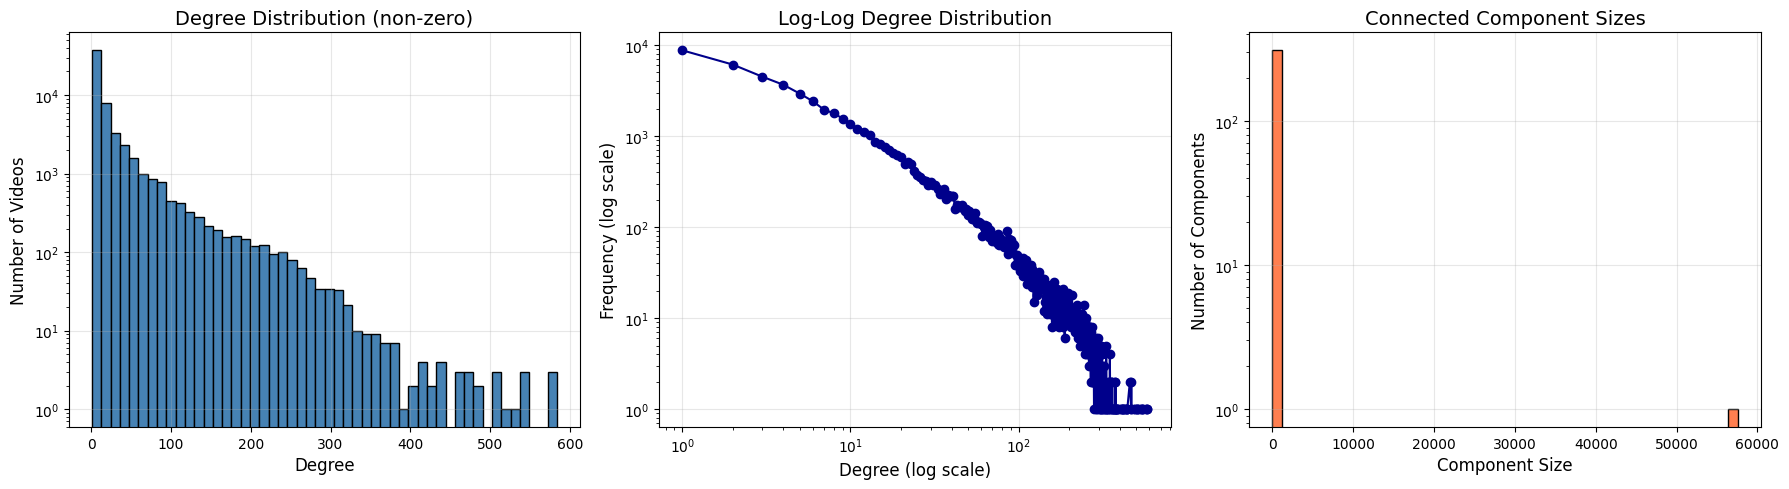

✓ Saved: network_analysis.png


In [57]:
# VISUALIZATION 1: Degree Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Degree histogram
ax = axes[0]
non_zero_degrees = [d for d in degree_values if d > 0]
ax.hist(non_zero_degrees, bins=50, edgecolor='black', color='steelblue')
ax.set_xlabel('Degree', fontsize=12)
ax.set_ylabel('Number of Videos', fontsize=12)
ax.set_title('Degree Distribution (non-zero)', fontsize=14)
ax.set_yscale('log')
ax.grid(alpha=0.3)

# Plot 2: Log-log degree distribution (power law check)
ax = axes[1]
from collections import Counter
degree_counts = Counter(degree_values)
degrees_sorted = sorted(degree_counts.items())
x_deg = [d for d, count in degrees_sorted if d > 0]
y_count = [count for d, count in degrees_sorted if d > 0]
ax.loglog(x_deg, y_count, 'o-', markersize=6, color='darkblue')
ax.set_xlabel('Degree (log scale)', fontsize=12)
ax.set_ylabel('Frequency (log scale)', fontsize=12)
ax.set_title('Log-Log Degree Distribution', fontsize=14)
ax.grid(alpha=0.3)

# Plot 3: Component size distribution
ax = axes[2]
component_sizes_nonzero = [s for s in component_sizes if s > 1]
if component_sizes_nonzero:
    ax.hist(component_sizes_nonzero, bins=min(50, len(component_sizes_nonzero)), 
            edgecolor='black', color='coral')
    ax.set_xlabel('Component Size', fontsize=12)
    ax.set_ylabel('Number of Components', fontsize=12)
    ax.set_title('Connected Component Sizes', fontsize=14)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('network_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: network_analysis.png")



Visualizing ego networks of top hub videos (IMPROVED VERSION)...

  Generating plot 1/3 for hub video: FCjiMVHbXlQ (degree: 584)


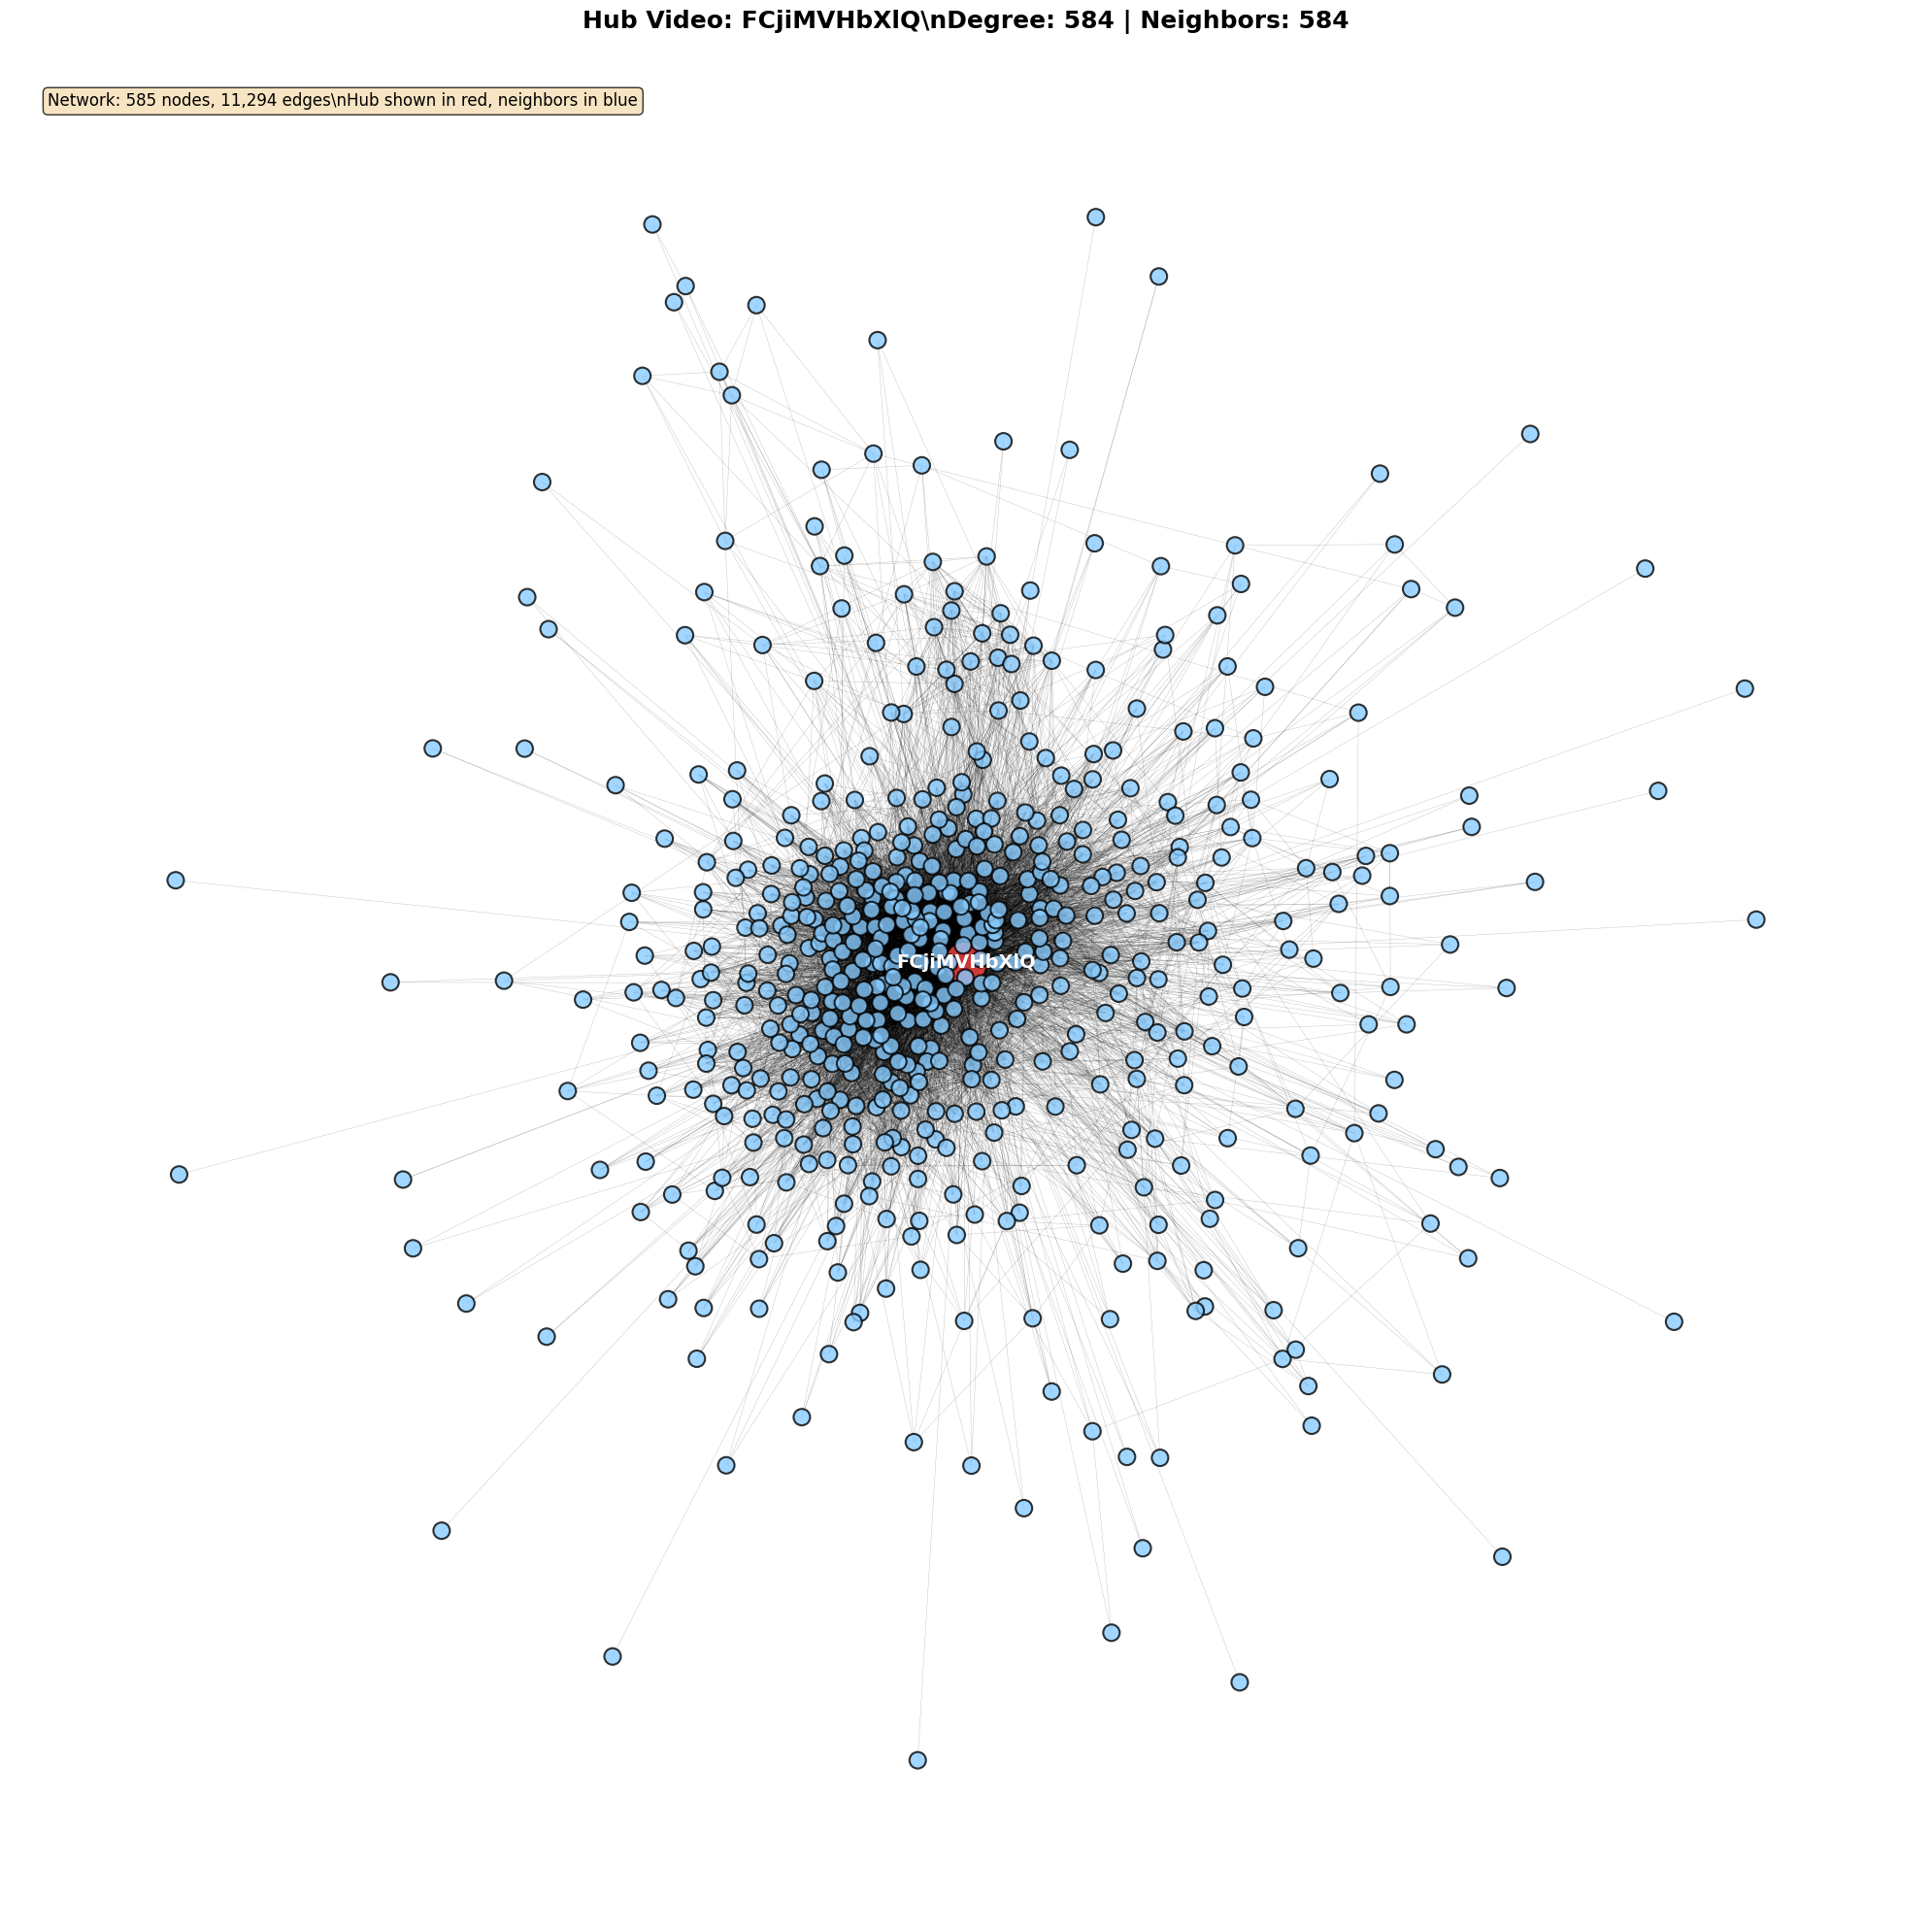

  ✓ Saved: network_hub_1_FCjiMVHbXlQ.png

  Generating plot 2/3 for hub video: NsrEb1aJxMY (degree: 580)


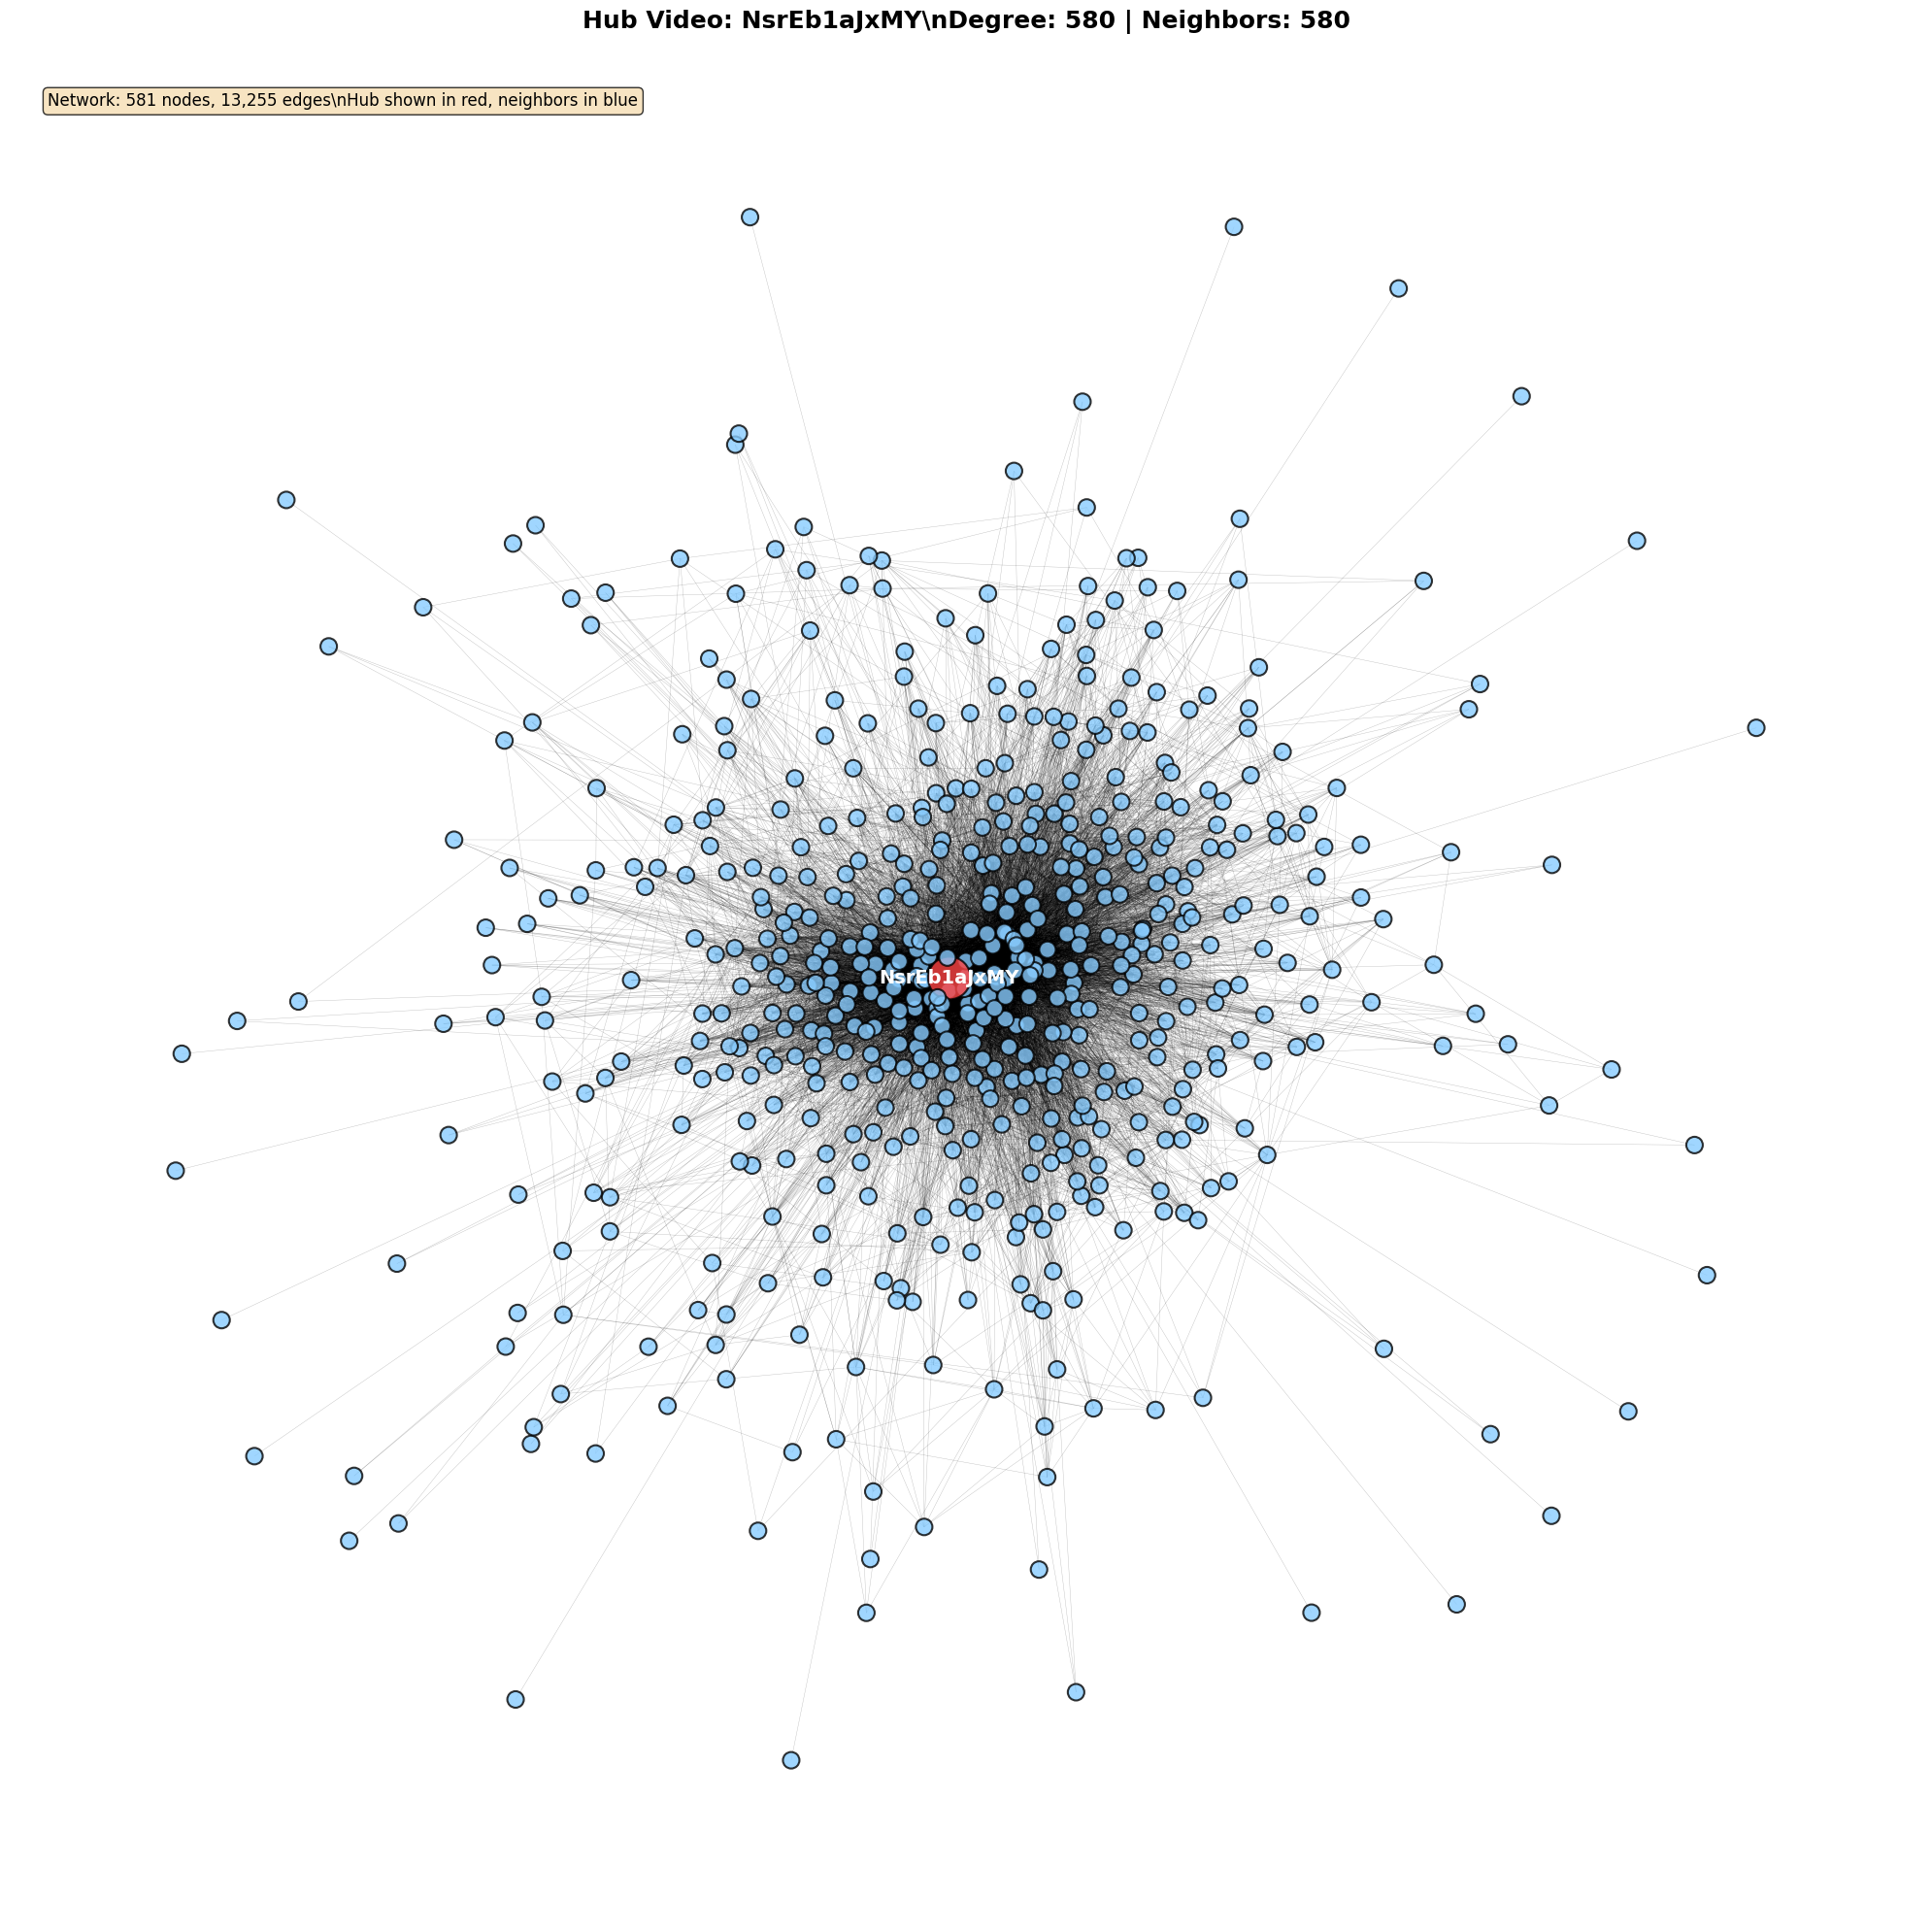

  ✓ Saved: network_hub_2_NsrEb1aJxMY.png

  Generating plot 3/3 for hub video: 8xFtIsyRvNE (degree: 573)


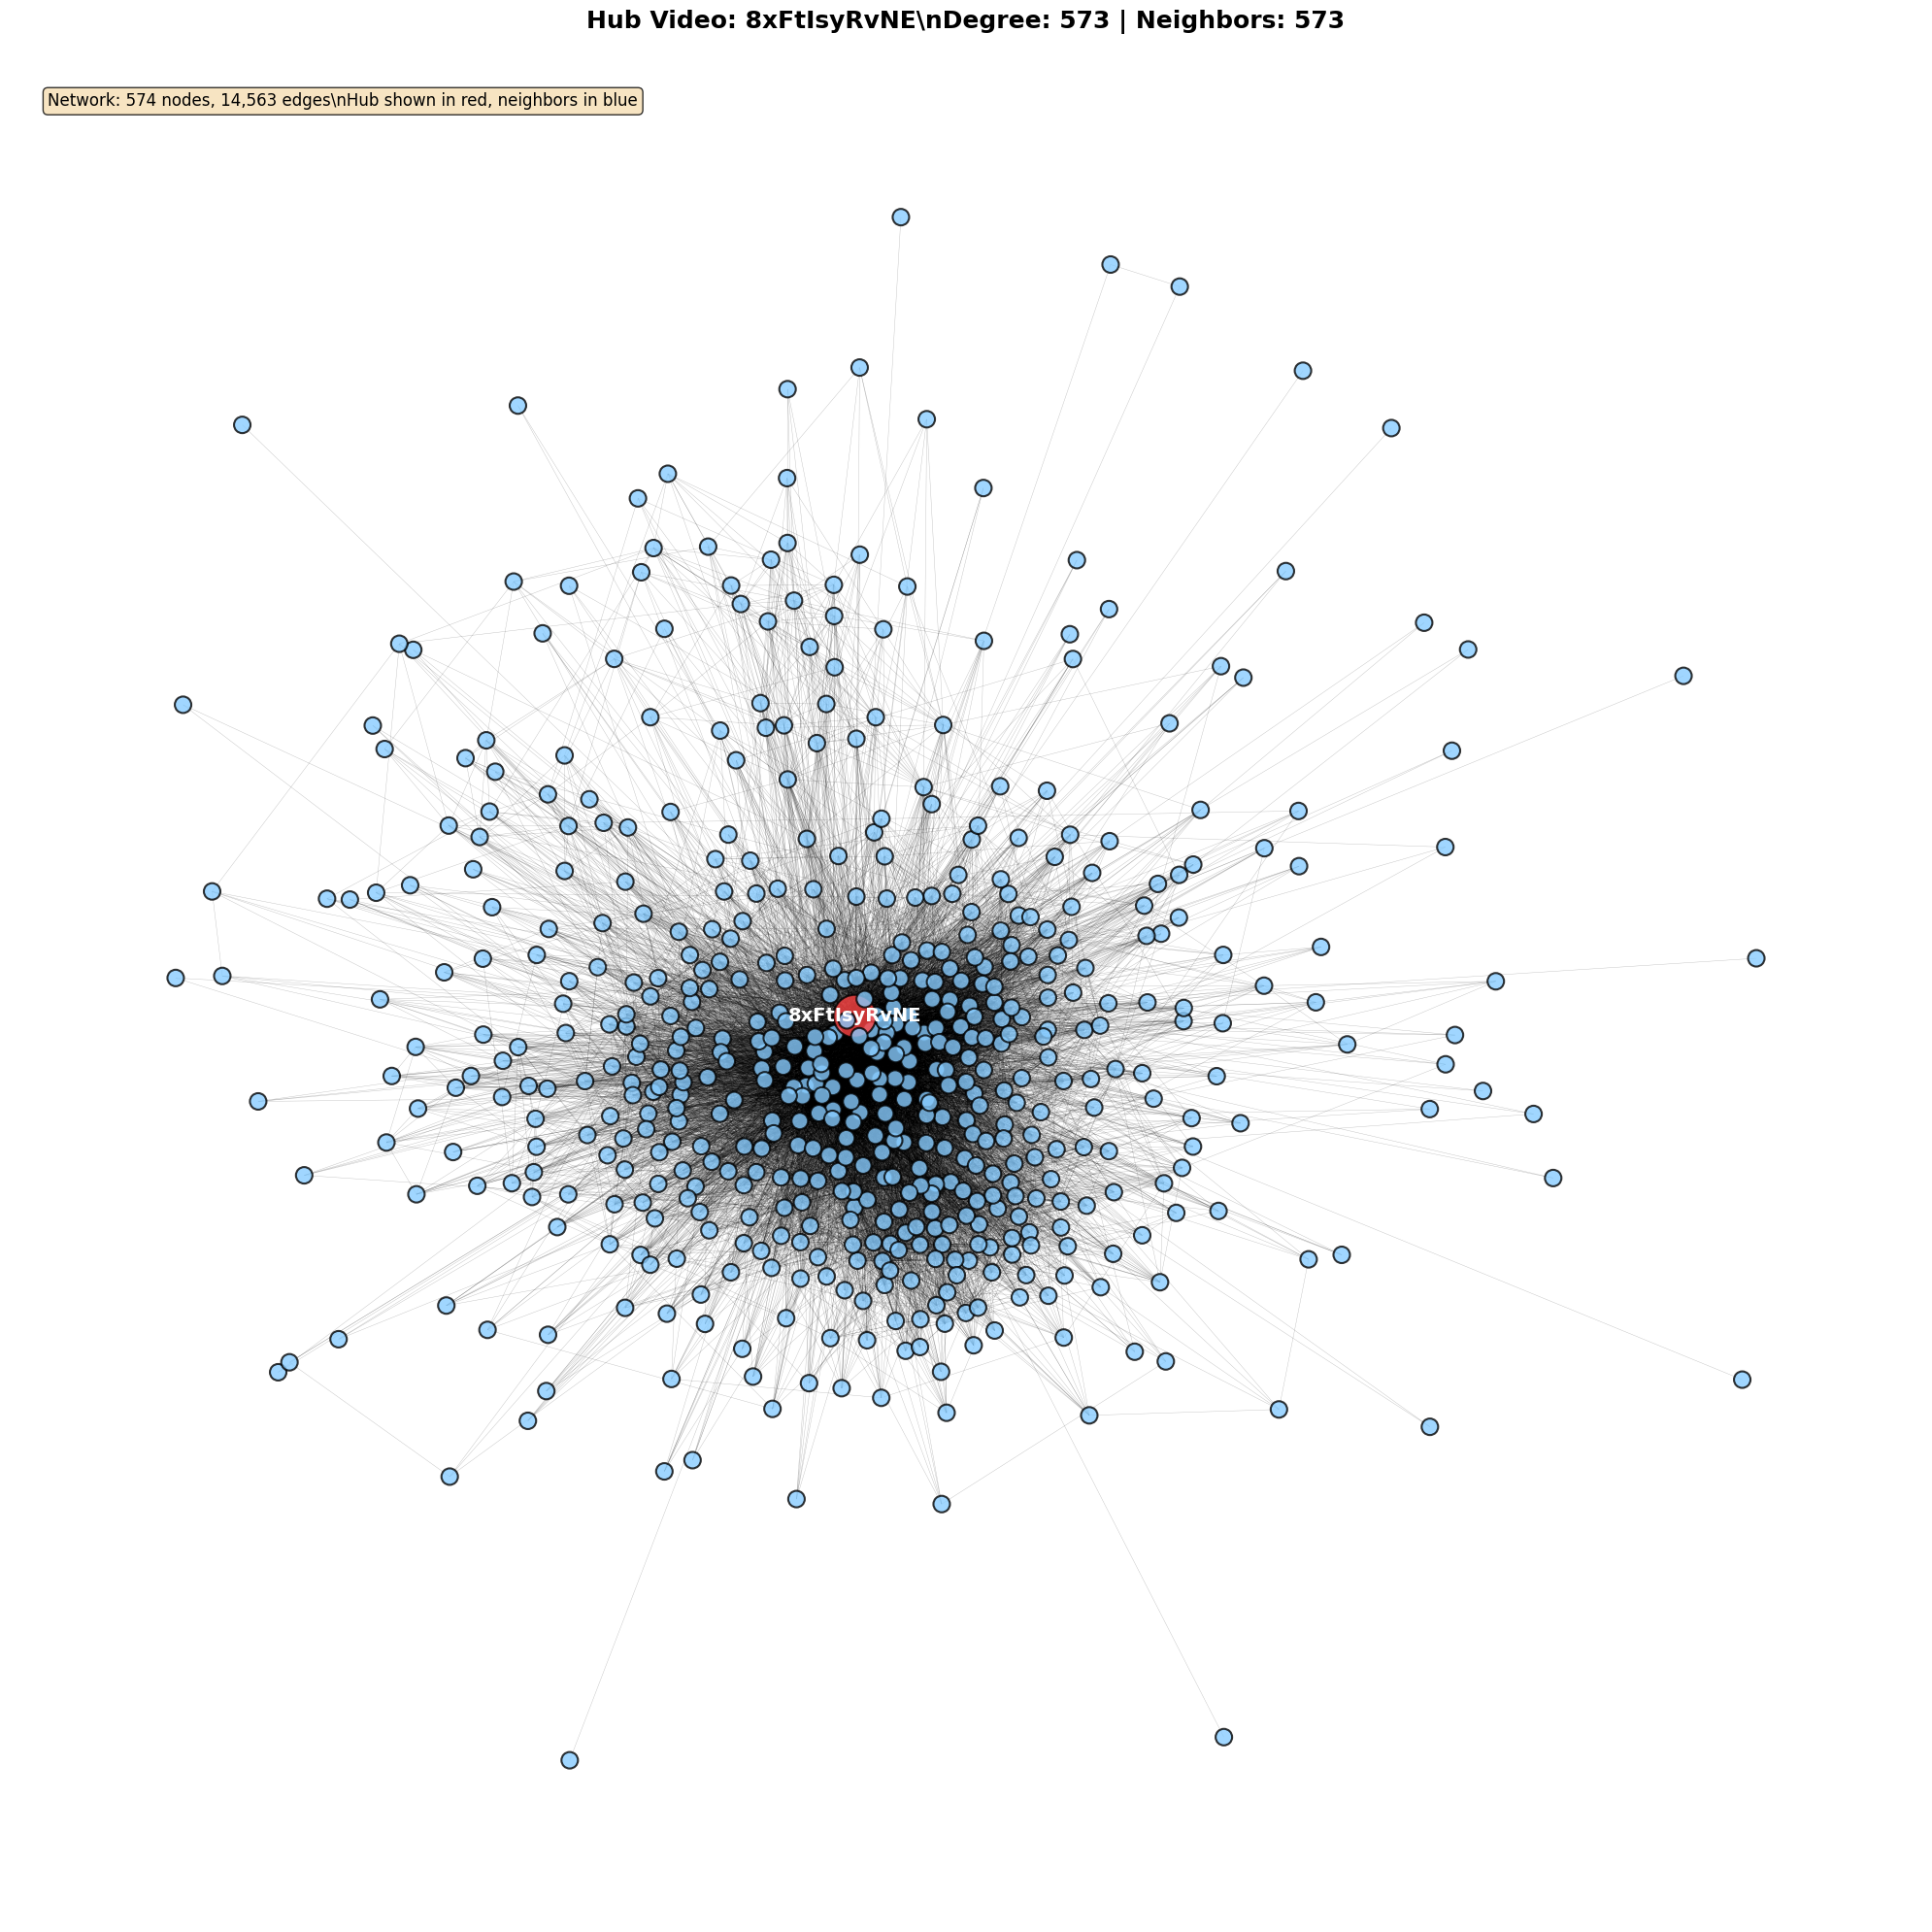

  ✓ Saved: network_hub_3_8xFtIsyRvNE.png

  Creating combined overview...


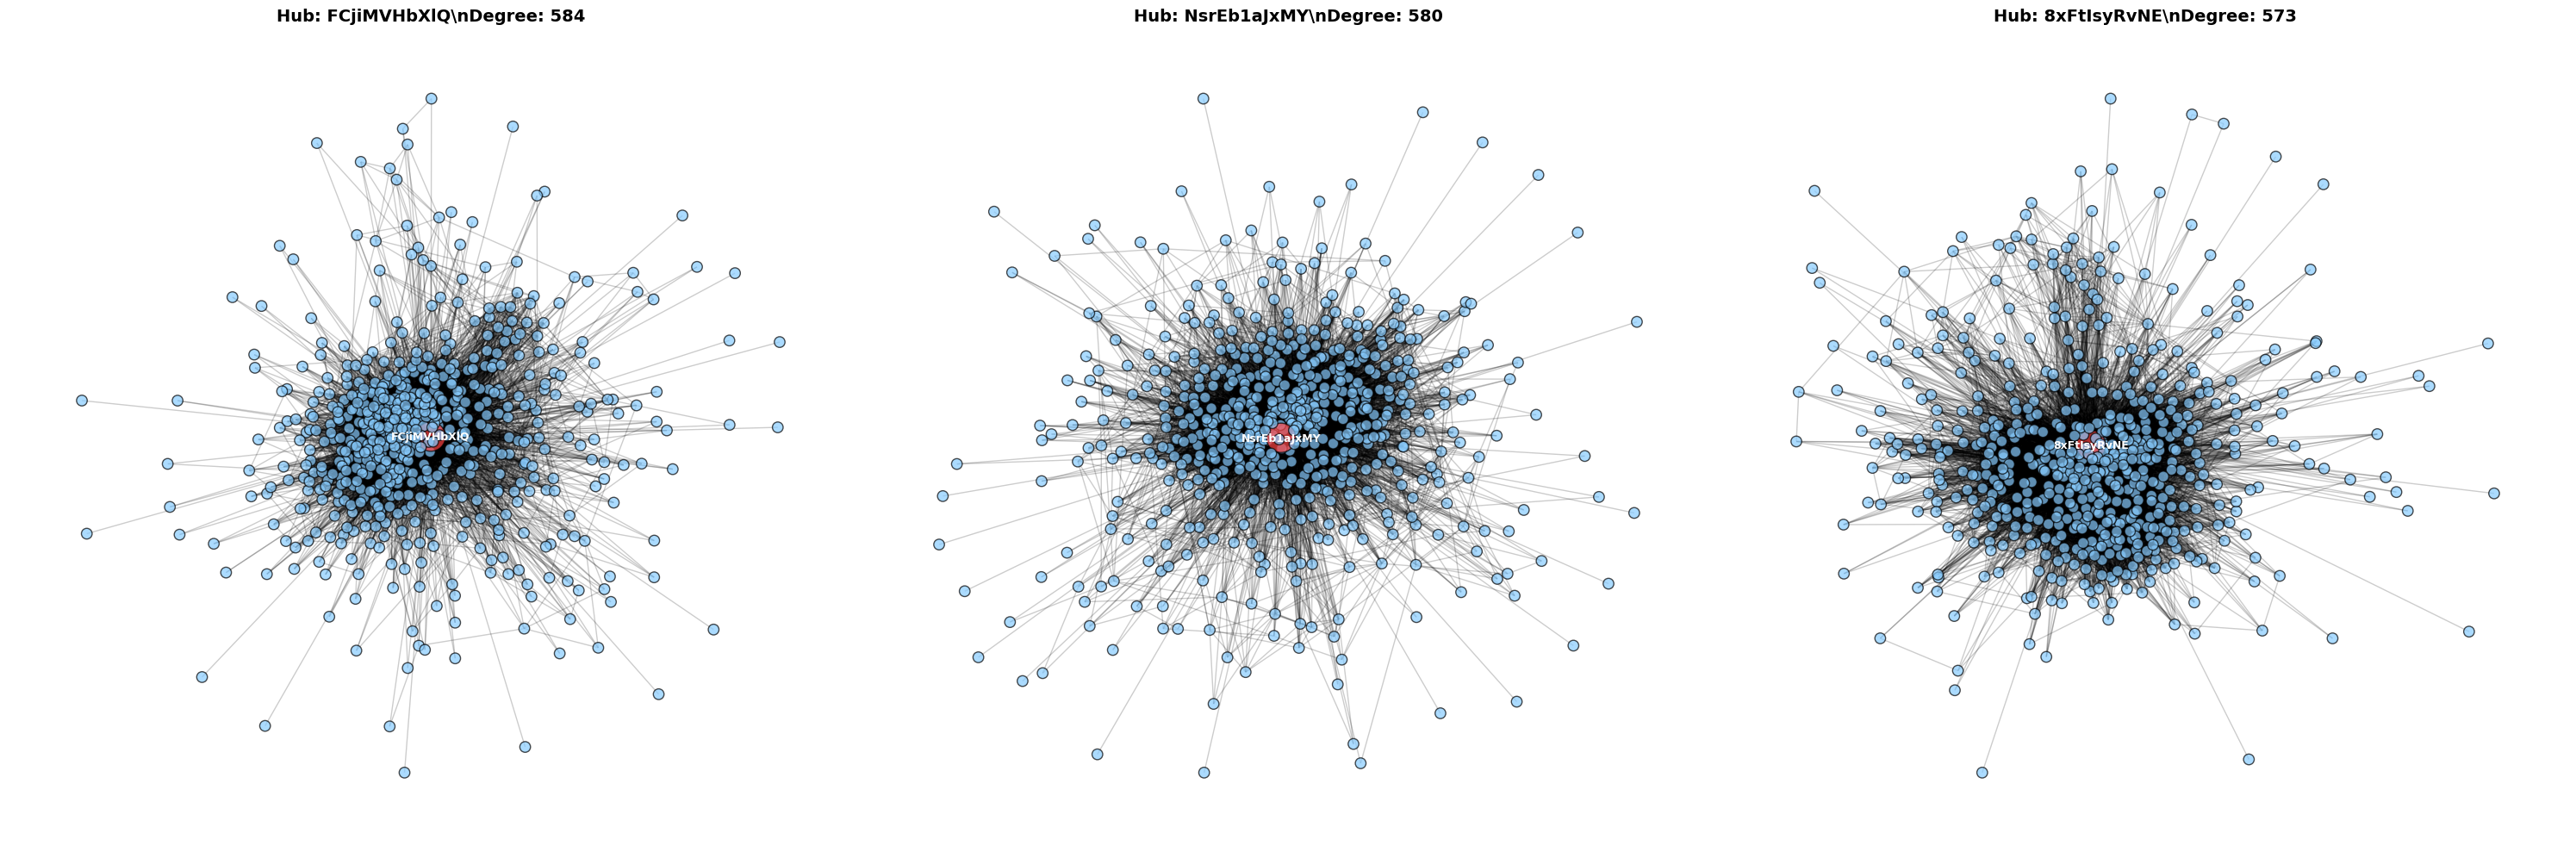

  ✓ Saved: network_hub_videos_overview.png

  Top 5 Hub Videos:
    FCjiMVHbXlQ                              → Degree: 584
    NsrEb1aJxMY                              → Degree: 580
    8xFtIsyRvNE                              → Degree: 573
    9q2PgfYbppY                              → Degree: 549
    rVWZuXDkc4A                              → Degree: 540


In [ ]:
# IMPROVED VISUALIZATION: Top Hub Videos (Ego Networks)
# Strategy: Make plots much larger and more readable

print("\nVisualizing ego networks of top hub videos (IMPROVED VERSION)...")

# Find top 5 hub videos (highest degree)
top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

if top_hubs[0][1] > 0:  # If there are any connections
    # Create SEPARATE large figures for each hub (much more readable!)
    for idx, (video, degree) in enumerate(top_hubs[:3]):
        if degree == 0:
            continue
        
        print(f"\n  Generating plot {idx+1}/3 for hub video: {video} (degree: {degree})")
            
        # Get ego network (1-hop neighborhood)
        ego = nx.ego_graph(G, video, radius=1)
        n_neighbors = ego.number_of_nodes() - 1
        
        # Create a LARGE figure for this single hub
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
        
        # Use a better layout algorithm with more spacing
        # k controls node spacing (higher = more spread out)
        k_value = 3 / np.sqrt(ego.number_of_nodes())  # Adaptive spacing
        pos = nx.spring_layout(ego, k=k_value, iterations=100, seed=42)
        
        # Color: hub video (red) vs neighbors (light blue)
        node_colors = ['#FF4444' if n == video else '#88CCFF' for n in ego.nodes()]
        node_sizes = [1000 if n == video else 150 for n in ego.nodes()]
        
        # Draw nodes with better visual properties
        nx.draw_networkx_nodes(ego, pos, node_color=node_colors, 
                              node_size=node_sizes, alpha=0.8, 
                              edgecolors='black', linewidths=1.5, ax=ax)
        
        # Draw edges with varying thickness based on weight
        edges = ego.edges()
        weights = [ego[u][v].get('w_jaccard', 0.1) * 3 for u, v in edges]
        nx.draw_networkx_edges(ego, pos, alpha=0.25, width=weights, ax=ax)
        
        # Label only the hub video (to avoid clutter)
        labels = {video: str(video)[:11]}
        nx.draw_networkx_labels(ego, pos, labels, font_size=14, 
                               font_weight='bold', font_color='white', ax=ax)
        
        ax.set_title(f'Hub Video: {str(video)}\\nDegree: {degree:,} | Neighbors: {n_neighbors:,}', 
                    fontsize=18, fontweight='bold', pad=20)
        ax.axis('off')
        
        # Add a text box with statistics
        textstr = f'Network: {ego.number_of_nodes():,} nodes, {ego.number_of_edges():,} edges\n'
        textstr += f'Hub shown in red, neighbors in blue'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        filename = f'network_hub_{idx+1}_{video}.png'
        plt.savefig(filename, dpi=200, bbox_inches='tight', facecolor='white')
        plt.show()
        print(f"  ✓ Saved: {filename}")
    
    # Also create a combined smaller overview
    print(f"\n  Creating combined overview...")
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    
    for idx, (video, degree) in enumerate(top_hubs[:3]):
        if degree == 0:
            continue
        
        ego = nx.ego_graph(G, video, radius=1)
        ax = axes[idx]
        
        # Better layout
        k_value = 2.5 / np.sqrt(ego.number_of_nodes())
        pos = nx.spring_layout(ego, k=k_value, iterations=80, seed=42)
        
        node_colors = ['#FF4444' if n == video else '#88CCFF' for n in ego.nodes()]
        node_sizes = [600 if n == video else 80 for n in ego.nodes()]
        
        nx.draw_networkx_nodes(ego, pos, node_color=node_colors, 
                              node_size=node_sizes, alpha=0.7, 
                              edgecolors='black', linewidths=1, ax=ax)
        nx.draw_networkx_edges(ego, pos, alpha=0.2, width=1, ax=ax)
        
        labels = {video: str(video)[:11]}
        nx.draw_networkx_labels(ego, pos, labels, font_size=9, 
                               font_weight='bold', font_color='white', ax=ax)
        
        ax.set_title(f'Hub: {str(video)[:20]}\\nDegree: {degree:,}', 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('network_hub_videos_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"  ✓ Saved: network_hub_videos_overview.png")
    
    print(f"\n  Top 5 Hub Videos:")
    for video, degree in top_hubs:
        print(f"    {str(video)[:40]:<40} → Degree: {degree}")


In [58]:
# VISUALIZATION 2: Largest Connected Component
print("\nVisualizing largest connected component...")

# Get largest component
largest_cc = max(nx.connected_components(G), key=len)
G_main = G.subgraph(largest_cc).copy()

print(f"Largest component: {G_main.number_of_nodes():,} nodes, {G_main.number_of_edges():,} edges")

# Only visualize if reasonably sized
if G_main.number_of_nodes() <= 1000:
    print("  Generating layout (this may take a moment)...")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # Layout 1: Spring layout (force-directed)
    ax = axes[0]
    pos = nx.spring_layout(G_main, k=0.5, iterations=50, seed=42)
    
    # Color nodes by degree
    node_colors = [G_main.degree(n) for n in G_main.nodes()]
    
    nx.draw_networkx_nodes(G_main, pos, node_color=node_colors, 
                          node_size=20, cmap='viridis', alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G_main, pos, alpha=0.3, width=0.5, ax=ax)
    ax.set_title(f'Largest Component ({G_main.number_of_nodes()} nodes)\nSpring Layout - Color by Degree', 
                fontsize=14)
    ax.axis('off')
    
    # Layout 2: Kamada-Kawai (if not too large)
    if G_main.number_of_nodes() <= 300:
        ax = axes[1]
        pos2 = nx.kamada_kawai_layout(G_main)
        nx.draw_networkx_nodes(G_main, pos2, node_color=node_colors, 
                              node_size=30, cmap='plasma', alpha=0.7, ax=ax)
        nx.draw_networkx_edges(G_main, pos2, alpha=0.3, width=0.8, ax=ax)
        ax.set_title(f'Kamada-Kawai Layout\nColor by Degree', fontsize=14)
        ax.axis('off')
    else:
        ax = axes[1]
        ax.text(0.5, 0.5, f'Component too large ({G_main.number_of_nodes()} nodes)\nfor Kamada-Kawai layout\n\nUse Gephi for better visualization!', 
                ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('network_visualization_main_component.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("  ✓ Saved: network_visualization_main_component.png")
else:
    print(f"  Component is too large ({G_main.number_of_nodes():,} nodes) for matplotlib visualization")
    print(f"  → Use Gephi instead! Open 'video_network.gexf' in Gephi for interactive exploration")



Visualizing largest connected component...
Largest component: 57,570 nodes, 653,498 edges
  Component is too large (57,570 nodes) for matplotlib visualization
  → Use Gephi instead! Open 'video_network.gexf' in Gephi for interactive exploration



Visualizing ego networks of top hub videos...


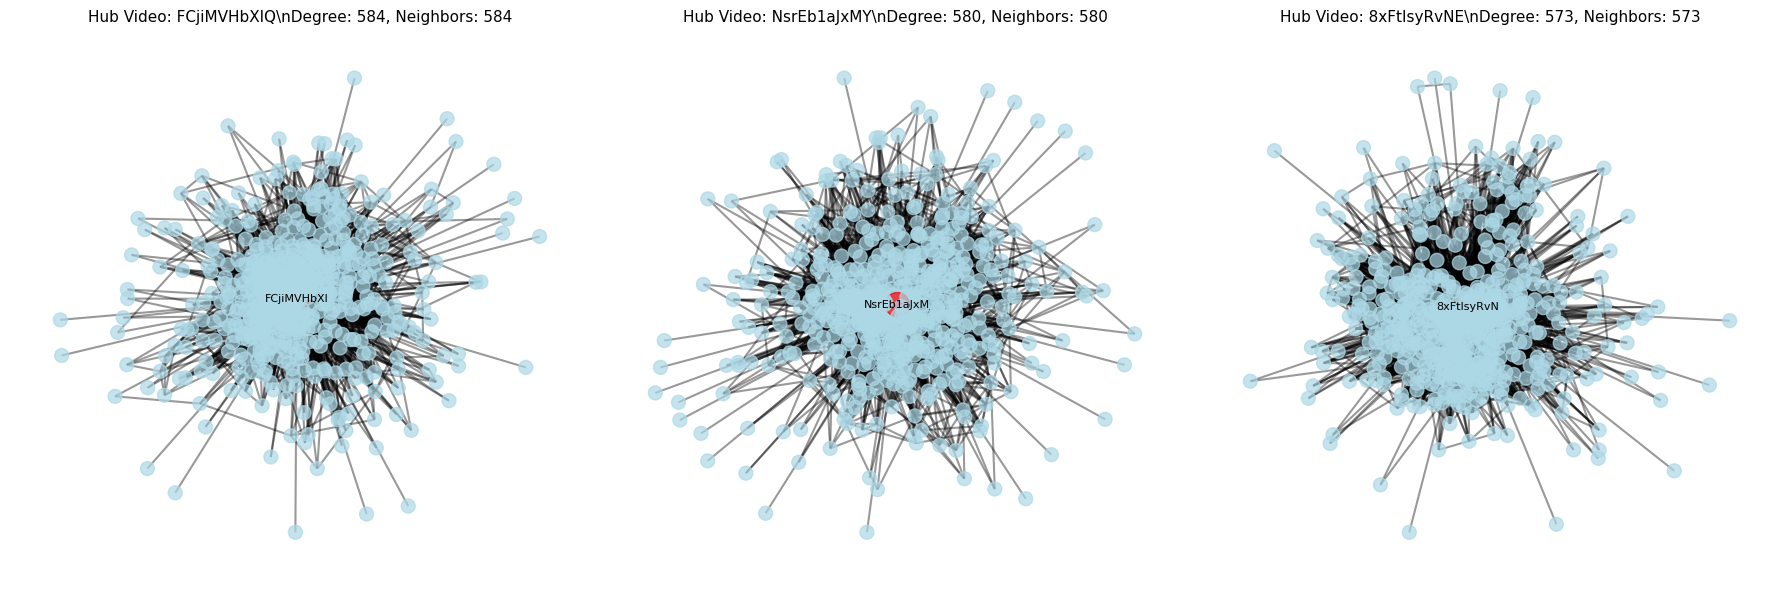

  ✓ Saved: network_hub_videos.png

  Top 5 Hub Videos:
    FCjiMVHbXlQ                              → Degree: 584
    NsrEb1aJxMY                              → Degree: 580
    8xFtIsyRvNE                              → Degree: 573
    9q2PgfYbppY                              → Degree: 549
    rVWZuXDkc4A                              → Degree: 540


In [59]:
# VISUALIZATION 3: Top Hub Videos (Ego Networks)
print("\nVisualizing ego networks of top hub videos...")

# Find top 5 hub videos (highest degree)
top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

if top_hubs[0][1] > 0:  # If there are any connections
    fig, axes = plt.subplots(1, min(3, len([h for h in top_hubs if h[1] > 0])), figsize=(18, 6))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    
    for idx, (video, degree) in enumerate(top_hubs[:3]):
        if degree == 0:
            continue
            
        # Get ego network (1-hop neighborhood)
        ego = nx.ego_graph(G, video, radius=1)
        
        ax = axes[idx] if len(axes) > 1 else axes[0]
        pos = nx.spring_layout(ego, k=1, iterations=50, seed=42)
        
        # Color: hub video vs neighbors
        node_colors = ['red' if n == video else 'lightblue' for n in ego.nodes()]
        node_sizes = [300 if n == video else 100 for n in ego.nodes()]
        
        nx.draw_networkx_nodes(ego, pos, node_color=node_colors, 
                              node_size=node_sizes, alpha=0.7, ax=ax)
        nx.draw_networkx_edges(ego, pos, alpha=0.4, width=1.5, ax=ax)
        
        # Label the hub
        labels = {video: str(video)[:10]}
        nx.draw_networkx_labels(ego, pos, labels, font_size=8, ax=ax)
        
        ax.set_title(f'Hub Video: {str(video)[:20]}\\nDegree: {degree}, Neighbors: {ego.number_of_nodes()-1}', 
                    fontsize=11)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('network_hub_videos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("  ✓ Saved: network_hub_videos.png")
    print(f"\n  Top 5 Hub Videos:")
    for video, degree in top_hubs:
        print(f"    {str(video)[:40]:<40} → Degree: {degree}")


## 📊 Interpretation Guide

### For Gephi (Professional Visualization):
1. **Open `video_network.gexf` in Gephi**
2. **Run Layout Algorithms**:
   - ForceAtlas 2 (good for large networks)
   - Fruchterman Reingold (force-directed)
3. **Color nodes by**: Community, Degree, Betweenness
4. **Filter by**: Degree ≥ 2, Component size ≥ 10
5. **Export** high-res images

### Key Metrics to Interpret:
- **Degree**: How many other videos this video connects to
- **Betweenness**: How important this video is for connecting communities
- **Community**: Which topic cluster this video belongs to
- **Component Size**: How isolated or connected a group is


# **MATCH VIDEO IDs WITH METADATA**


In [41]:
# Load video metadata
import json

print("Loading video metadata...")
metadata_path = '/Users/albertfares/Desktop/4650046/yt_metadata_en.jsonl'

# Read JSONL file and create a lookup dictionary
video_metadata = {}
with open(metadata_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading metadata")):
        try:
            video = json.loads(line.strip())
            video_id = video.get('video_id') or video.get('id')  # Try both common field names
            if video_id:
                video_metadata[video_id] = {
                    'title': video.get('title', 'No title'),
                    'channel': video.get('channel', video.get('channel_title', 'Unknown')),
                    'views': video.get('view_count', video.get('views', 0)),
                    'upload_date': video.get('upload_date', 'Unknown'),
                    'categories': video.get('categories', [])
                }
        except json.JSONDecodeError:
            continue
        
        # Optional: limit for faster testing
        if i >= 1_000_000:  # Load first 1M videos
            break

print(f"\nLoaded metadata for {len(video_metadata):,} videos")


Loading video metadata...


Reading metadata: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [60]:
# Get top hub videos with their metadata
print("="*80)
print("TOP HUB VIDEOS (Highest Degree)")
print("="*80)

top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]

for rank, (video_id, degree) in enumerate(top_hubs, 1):
    if degree == 0:
        continue
    
    # Look up metadata
    meta = video_metadata.get(video_id, {})
    title = meta.get('title', 'Metadata not found')
    channel = meta.get('channel', 'Unknown')
    views = meta.get('views', 0)
    
    print(f"\n{rank}. Video ID: {video_id}")
    print(f"   Title: {title[:80]}")  # Truncate long titles
    print(f"   Channel: {channel}")
    print(f"   Views: {views:,}" if isinstance(views, int) else f"   Views: {views}")
    print(f"   Network Degree: {degree} (shares commenters with {degree} videos)")
    print(f"   URL: https://www.youtube.com/watch?v={video_id}")
    print(f"   {'-'*78}")


TOP HUB VIDEOS (Highest Degree)

1. Video ID: FCjiMVHbXlQ
   Title: Metadata not found
   Channel: Unknown
   Views: 0
   Network Degree: 584 (shares commenters with 584 videos)
   URL: https://www.youtube.com/watch?v=FCjiMVHbXlQ
   ------------------------------------------------------------------------------

2. Video ID: NsrEb1aJxMY
   Title: Metadata not found
   Channel: Unknown
   Views: 0
   Network Degree: 580 (shares commenters with 580 videos)
   URL: https://www.youtube.com/watch?v=NsrEb1aJxMY
   ------------------------------------------------------------------------------

3. Video ID: 8xFtIsyRvNE
   Title: Metadata not found
   Channel: Unknown
   Views: 0
   Network Degree: 573 (shares commenters with 573 videos)
   URL: https://www.youtube.com/watch?v=8xFtIsyRvNE
   ------------------------------------------------------------------------------

4. Video ID: 9q2PgfYbppY
   Title: Metadata not found
   Channel: Unknown
   Views: 0
   Network Degree: 549 (shares commenters

In [28]:
# If you computed betweenness, show top videos by betweenness too
if 'betw' in locals() and betw:
    print("\n" + "="*80)
    print("TOP PATHWAY VIDEOS (Highest Betweenness Centrality)")
    print("="*80)
    print("These videos act as bridges between different communities\n")
    
    top_betweenness = sorted(betw.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for rank, (video_id, betw_score) in enumerate(top_betweenness, 1):
        if betw_score == 0:
            continue
        
        # Look up metadata
        meta = video_metadata.get(video_id, {})
        title = meta.get('title', 'Metadata not found')
        channel = meta.get('channel', 'Unknown')
        degree_val = degrees.get(video_id, 0)
        
        print(f"{rank}. Video ID: {video_id}")
        print(f"   Title: {title[:80]}")
        print(f"   Channel: {channel}")
        print(f"   Betweenness: {betw_score:.6f}")
        print(f"   Degree: {degree_val}")
        print(f"   URL: https://www.youtube.com/watch?v={video_id}")
        print(f"   {'-'*78}\n")



TOP PATHWAY VIDEOS (Highest Betweenness Centrality)
These videos act as bridges between different communities

1. Video ID: hSlb1ezRqfA
   Title: Metadata not found
   Channel: Unknown
   Betweenness: 0.319233
   Degree: 58
   URL: https://www.youtube.com/watch?v=hSlb1ezRqfA
   ------------------------------------------------------------------------------

2. Video ID: PHgc8Q6qTjc
   Title: Metadata not found
   Channel: Unknown
   Betweenness: 0.251112
   Degree: 54
   URL: https://www.youtube.com/watch?v=PHgc8Q6qTjc
   ------------------------------------------------------------------------------

3. Video ID: QwZT7T-TXT0
   Title: Metadata not found
   Channel: Unknown
   Betweenness: 0.238539
   Degree: 24
   URL: https://www.youtube.com/watch?v=QwZT7T-TXT0
   ------------------------------------------------------------------------------

4. Video ID: Rfs-4DPlm7I
   Title: Metadata not found
   Channel: Unknown
   Betweenness: 0.213131
   Degree: 50
   URL: https://www.youtube.com

In [29]:
# Export enriched node data with titles
print("\nExporting enriched node data with video titles...")

# Read existing nodes file and enrich with metadata
nodes_df = pd.read_csv('video_network_nodes.csv')

# Add metadata columns
nodes_df['title'] = nodes_df['video_id'].apply(lambda x: video_metadata.get(x, {}).get('title', 'Not found'))
nodes_df['channel'] = nodes_df['video_id'].apply(lambda x: video_metadata.get(x, {}).get('channel', 'Unknown'))
nodes_df['views'] = nodes_df['video_id'].apply(lambda x: video_metadata.get(x, {}).get('views', 0))
nodes_df['upload_date'] = nodes_df['video_id'].apply(lambda x: video_metadata.get(x, {}).get('upload_date', 'Unknown'))

# Add degree from network
nodes_df['degree'] = nodes_df['video_id'].apply(lambda x: degrees.get(x, 0))

# Sort by degree (most connected first)
nodes_df = nodes_df.sort_values('degree', ascending=False)

# Save enriched version
nodes_df.to_csv('video_network_nodes_enriched.csv', index=False)
print(f"✓ Saved: video_network_nodes_enriched.csv ({len(nodes_df):,} videos)")

# Show sample
print("\nSample of enriched data:")
display(nodes_df.head(10)[['video_id', 'title', 'channel', 'degree', 'betweenness', 'community']])



Exporting enriched node data with video titles...
✓ Saved: video_network_nodes_enriched.csv (599,716 videos)

Sample of enriched data:


video_id      title  channel  degree  betweenness  community
104102  A4rBWxEfd7Q  Not found  Unknown      70     0.000000        NaN
182403  IRAJoghOa7c  Not found  Unknown      63     0.000000        NaN
414481  gGJTAi6A92o  Not found  Unknown      60     0.000000        NaN
425927  hSlb1ezRqfA  Not found  Unknown      58     0.319233        NaN
246440  PHgc8Q6qTjc  Not found  Unknown      54     0.251112        NaN
431598  i28_1LBq4VY  Not found  Unknown      53     0.000000        NaN
128460  Cg_2xecKTDQ  Not found  Unknown      52     0.000000        NaN
222377  MhTw1SUxWTA  Not found  Unknown      50     0.091851        NaN
268562  Rfs-4DPlm7I  Not found  Unknown      50     0.213131        NaN
338679  ZAxhEUfpSss  Not found  Unknown      45     0.064794        NaN